## Set up Workspace

In [1]:
#cd kddm/data/uas 

In [2]:
#ls

### Steps

1. Read in an explore data
2. Regrid to 0.25 deg Lat-Lon grid
3. Alignepochs.R-esque function to get moving windows
4. biascorrection.R-esque function for Z-score correction of _ward wind
5. Save file
6. Compare to corrected historical and rcp85 model

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import interpolate
import xesmf as xe
import pandas as pd
from calendar import isleap
from dateutil import relativedelta as rd
from datetime import datetime, timedelta
import cftime

In [4]:
%matplotlib inline

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Look at Data

In [5]:
#Use Intake ESM for this when on Cheyenne again!


path = '../../kddm/data/uas/'
measured = xr.open_dataset(path+'uas.METDATA.44i.nc', chunks = {'time':5})
hist = xr.open_dataset(path+'uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc', chunks = {'time':5})
rcp85 = xr.open_dataset(path+'uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.nc', chunks = {'time':5})

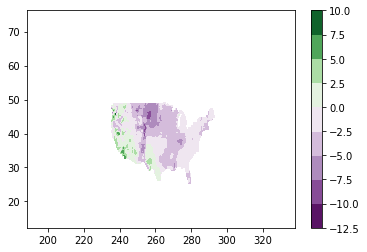

In [6]:
plt.contourf(measured.lon, measured.lat, measured.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

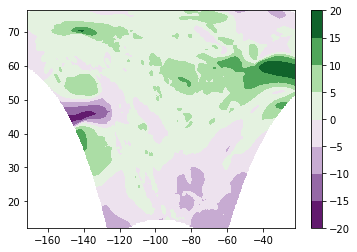

In [7]:
plt.contourf(hist.lon, hist.lat, hist.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

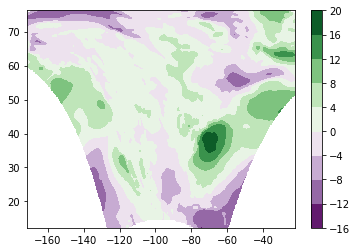

In [8]:
plt.contourf(rcp85.lon, rcp85.lat, rcp85.uas.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

## Filter and Regrid Data to Quarter Degree Grid

In [9]:
measured_droplats = measured.dropna(dim='lat', how ='all')
measured_flt = measured_droplats.dropna(dim='lon', how='all')

In [10]:
lon_min = float(np.min(measured_flt.lon))
lon_max = float(np.max(measured_flt.lon))
lat_min = float(np.min(measured_flt.lat))
lat_max = float(np.max(measured_flt.lat))
wesn = [lon_min, lon_max, lat_min, lat_max]

In [11]:
grid = 0.25
wesn_g = [int(round(i * 4)) / 4 for i in wesn]

new_lon = np.arange(wesn_g[0],wesn_g[1], grid)
new_lat = np.arange(wesn_g[2], wesn_g[3]+grid, grid)

ds_newgrid = xr.Dataset({'lat': (['lat'], new_lat), 'lon': (['lon'], new_lon)})

In [12]:
regridder_measured = xe.Regridder(measured_flt, ds_newgrid, 'bilinear')
measured_rgrd = regridder_measured(measured_flt.uas)

Overwrite existing file: bilinear_49x116_97x230.nc 
 You can set reuse_weights=True to save computing time.


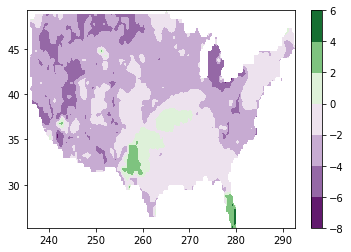

In [13]:
plt.contourf(measured_rgrd.lon, measured_rgrd.lat, measured_rgrd.isel(time=300), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

In [14]:
def force_pos_lon(ds):
    ds_poslon = ds.assign_coords(lon = ds.lon+ 360) if (np.min(ds.lon) < 0) else ds
    return ds_poslon

def regrid_model_coords(ds, wesn, newgrid):
    ds_poslon = force_pos_lon(ds)
    ds_flt = ds_poslon.sel(lon = slice(wesn[0], wesn[1]),lat = slice(wesn[2], wesn[3]))
    regridder_ds = xe.Regridder(ds_flt, newgrid, 'bilinear')
    ds_rgrd = regridder_ds(ds_flt.uas)
    return ds_rgrd

In [15]:
hist_rgrd = regrid_model_coords(hist, wesn, ds_newgrid)

Overwrite existing file: bilinear_49x116_97x230.nc 
 You can set reuse_weights=True to save computing time.


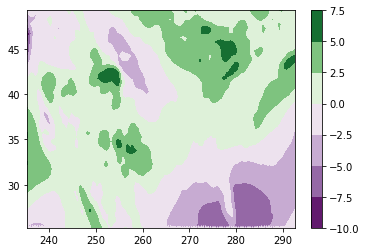

In [16]:
plt.contourf(hist_rgrd.lon, hist_rgrd.lat, hist_rgrd.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

In [17]:
rcp85_rgrd = regrid_model_coords(rcp85, wesn, ds_newgrid)

Overwrite existing file: bilinear_49x116_97x230.nc 
 You can set reuse_weights=True to save computing time.


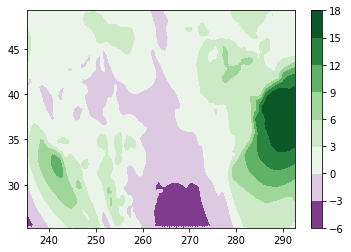

In [18]:
plt.contourf(rcp85_rgrd.lon, rcp85_rgrd.lat, rcp85_rgrd.isel(time=0), norm=MidpointNormalize(midpoint=0.), cmap='PRGn')
plt.colorbar()

In [ ]:
#Put NaN's where there is always NaN in measured

## Align Time

In [19]:
def check_calendars(da_measured, da_hist_model, da_fut_model):
    cal_measured = da_measured.time.encoding['calendar']
    cal_hist = da_hist_model.time.encoding['calendar']
    cal_fut = da_fut_model.time.encoding['calendar']
    return cal_measured, cal_hist, cal_fut

cal_measured, cal_hist, cal_fut = check_calendars(measured_rgrd, hist_rgrd, rcp85_rgrd)  

In [20]:
def cfnoleap_to_datetime(da):
    datetimeindex = da.indexes['time'].to_datetimeindex()
    ds = da.to_dataset()
    ds['time_dt']= ('time', datetimeindex)
    ds = ds.swap_dims({'time': 'time_dt'})
    assert len(da.time) == len(ds.time_dt)
    return ds

#Add a check here that uses info from checking the calendars?
ds_hist_dt = cfnoleap_to_datetime(hist_rgrd) 
ds_fut_dt = cfnoleap_to_datetime(rcp85_rgrd)  

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [21]:
def regroup_models_bytime(da_measured, ds_hist_model, ds_fut_model, cal_hist, cal_fut):
    t0_measured = da_measured.time[0]
    t_last_measured = da_measured.time[-1]
    t0_fut = t_last_measured.values + np.timedelta64(1, 'D')
    
    ds_hist_late = ds_hist_model.sel(time_dt = slice(t0_measured, None))
    
    can_concat_models = (cal_hist == cal_fut)
    if (can_concat_models == True):
        ds_fut_early = ds_fut_model.sel(time_dt = slice(None,t_last_measured))
        ds_fut_model = ds_fut_model.sel(time_dt = slice(t0_fut,None))
        ds_past_model = xr.concat((ds_hist_late, ds_fut_early), dim='time_dt')
    else:
        ds_past_model = ds_hist_late
    return ds_past_model, ds_fut_model

ds_past_model, ds_future_model = regroup_models_bytime(measured_rgrd, ds_hist_dt, ds_fut_dt, cal_hist, cal_fut)

In [22]:
def cal_interpolate(da_measured, ds_past_model, cal_measured):
    if (cal_measured == 'gregorian'):
        years = da_measured.time.dt.year
        leap_bool = [isleap(y) for y in set(years.values)]

        da_measured_noleap = da_measured.interp(time = ds_past_model.time_dt)
        da_measured_noleap.coords['time'] = ds_past_model.time
        assert len(da_measured_noleap.time) - len(ds_past_model.time_dt) == 0
    else:
        print('Only measured data on a gregorian calendar is supported at this time')
    return da_measured_noleap

da_measured_noleap = cal_interpolate(measured_rgrd, ds_past_model, cal_measured)

In [23]:
da_measured_swappedtime = da_measured_noleap.swap_dims({'time_dt':'time'})
ds_modeled_swappedtime = ds_past_model.swap_dims({'time_dt':'time'})
ds_fut_swappedtime = ds_future_model.swap_dims({'time_dt':'time'})

In [24]:
#Seth suggests subsampling instead of interpolating
#Interp okay for continuous variables
#Interp not good for spiky discontinuos variables (precipitation!)
#Make an align_calendars function that provides options, interpolation or subsampling randomly placed
#Print total amount of precipitation that was dropped in subsampling?

## Grouby Average for Every Day Across Years
#### (Dec 15 -> full 12 months -> Jan 15)

In [38]:
measured_avyear = da_measured_swappedtime.groupby('time.dayofyear').mean(dim='time')
model_avyear = ds_modeled_swappedtime.groupby('time.dayofyear').mean(dim='time')
fut_avyear = ds_fut_swappedtime.groupby('time.dayofyear').mean(dim='time')

In [86]:
def hack_circular_rolling(ds_avyear):
    last = ds_avyear.isel(dayofyear=slice(-15, None))
    last['dayofyear'] = np.arange(-15,0)
    
    first = ds_avyear.isel(dayofyear=slice(0, 15))
    first['dayofyear'] = np.arange(366,381)
    
    ds_circ = xr.concat([last, ds_avyear, first], 'dayofyear')
    return ds_circ;

measured_circ = hack_circular_rolling(measured_avyear)
past_circ = hack_circular_rolling(model_avyear)
fut_circ = hack_circular_rolling(fut_avyear)

## Z-Score Bias Correction Method

In [42]:
#Moving window
mv_window_w = 31

In [87]:
def get_stats(ds_avyear, ds_circ): 
    ds_mean = ds_circ.rolling(dayofyear=mv_window_w, center=True).mean()
    ds_mean = ds_mean.sel(dayofyear = slice(1, 365))

    ds_std = ds_circ.rolling(dayofyear=mv_window_w, center=True).std()
    ds_std = ds_std.sel(dayofyear = slice(1, 365))

    ds_zscore = (ds_avyear - ds_mean) / ds_std
    return ds_mean, ds_std, ds_zscore;

measured_mean, measured_std, measured_zscore = get_stats(measured_avyear, measured_circ)
model_mean, model_std, model_zscore = get_stats(model_avyear, past_circ)
fut_mean, fut_std, fut_zscore = get_stats(fut_avyear, fut_circ)

In [88]:
shift = measured_mean - model_mean
scale = measured_std - model_std

In [89]:
new_mean_past = model_mean + shift
new_std_past = model_std * scale

new_mean = fut_mean + shift
new_std = fut_std * scale

In [90]:
past_corrected = (model_zscore * new_std_past) + new_mean_past
fut_corrected = (fut_zscore * new_std) + new_mean